In [1]:
import numpy as np
import pandas as pd
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Setup Up GPU (Device)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load Data

In [3]:
df_tr = pd.read_csv("data/train.csv")
df_te = pd.read_csv('data/test_public.csv')

In [6]:
df_tr.shape

(1710670, 9)

In [5]:
df_te.shape

(320, 8)

In [4]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


# Helper Functions

In [7]:
# Over every single 
# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
def polyline_to_trip_duration(polyline):
    return max(polyline.count("[") - 2, 0) * 15

# Each x is essentially a 1 row, 1 column pandas Series
def parse_time(x):
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Feature Engineering/Selection

In [8]:
# process new features
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
df_te[["YR", "MON", "DAY", "HR", "WK"]] = df_te[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [9]:
def compute_ohe(df, feat):
    df = df.copy()
    unique_vals = df_tr[feat].unique()
    for val in unique_vals:
        df[feat + '_' + str(val)] = df[feat].apply(lambda x: 1 if x==val else 0)
    return df

In [10]:
# drop samples with missing data (count=10)
df_tr = df_tr[df_tr['MISSING_DATA'] == False]

In [11]:
# # drop samples with len < len_thresh
# len_thresh = 2000
# df_tr = df_tr[df_tr['LEN'] < len_thresh]

In [12]:
def drop_not_in_testing(df, feat):
    temp = (df_tr[feat].value_counts(normalize=True).sort_index() - df_te[feat].value_counts(normalize=True).sort_index())
    vals_to_remove = temp[temp.isna()].index
    df = df[df[feat].apply(lambda x: x not in vals_to_remove)]
    return df

In [13]:
features_to_use = ['CALL_TYPE', 'HR', 'WK']
# for feat in features_to_use:
#     df_tr = drop_not_in_testing(df_tr, feat)

In [14]:
# select useful input features
# features_to_use = ['CALL_TYPE_A', 'CALL_TYPE_B', 'CALL_TYPE_C', 'MON', 'DAY', 'HR', 'WK']

X = df_tr[features_to_use]
for feat in features_to_use:
    X = compute_ohe(X, feat)
X = X.drop(columns=features_to_use)
y = df_tr['LEN']

# Train Test Split

In [15]:
# split into train,validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
X_train.shape

(1197462, 34)

In [17]:
X_test.shape

(513198, 34)

In [14]:
# drop samples with len < len_thresh
len_thresh = 1415
train_data = pd.concat([X_train, y_train], axis=1)
train_data = train_data[train_data['LEN'] < len_thresh]
X_train = train_data.drop(columns='LEN')
y_train = train_data['LEN']

# Sklearn Baseline

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [16]:
reg = LinearRegression(n_jobs=-1)
reg.fit(X_train, y_train)
print(MSE(reg.predict(X_train), y_train, squared=False))
MSE(reg.predict(X_test), y_test, squared=False)

299.3913883377625


696.3676646514958

In [17]:
forest = RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42)
forest.fit(X_train, y_train)
print(MSE(forest.predict(X_train), y_train, squared=False))
MSE(forest.predict(X_test), y_test, squared=False)

299.30355949423944


697.0101929065416

# Convert to Tensors

In [18]:
# convert to tensors
X_train = torch.from_numpy(X_train.values).to(torch.float32)
y_train = torch.tensor(np.array(y_train)).to(torch.float32).reshape(-1,1)
X_test = torch.from_numpy(X_test.values).to(torch.float32)
y_test = torch.tensor(np.array(y_test)).to(torch.float32).reshape(-1,1)

data_train = TensorDataset(X_train, y_train)
data_test = TensorDataset(X_test, y_test)

batch_size = 2**8
num_workers = 4
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Deep Learning Model

In [19]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        eps = 1e-6
        loss = torch.sqrt(criterion(x, y) + eps)
        return loss

In [20]:
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(X.shape[1], 32),
            nn.LeakyReLU(0.1),
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(32,16),
            nn.LeakyReLU(0.1),
        )

        self.layerx = nn.Sequential(
            nn.Linear(16,16),
            nn.LeakyReLU(0.1)
        )
        
        self.layer4 = nn.Sequential(
            nn.Linear(16,8),
            nn.LeakyReLU(0.1)
        )
        
        self.layer5 = nn.Sequential(
            nn.Linear(8,1)
        )
        
    def forward(self, x):
        x = self.layer1(x)      
        x = self.layer2(x)
        
        x = self.layerx(x)
        
        x = self.layer4(x)      
        x = self.layer5(x)    
        return x

# Train Model

In [30]:
from tqdm import tqdm

training_losses = []
criterion = nn.MSELoss()
net = model()
net.to(device)
# optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

TOTAL_EPOCHS = 3

for epoch in tqdm(range(1, TOTAL_EPOCHS + 1, 1)):
    running_loss = 0
    n = 0 #len(data_train)
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        y_pred = net(x)
        loss  = criterion(y_pred, y)
        running_loss += loss.item()*len(x)
        n += len(x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
    curr_loss = np.sqrt(running_loss / n)
    training_losses.append((epoch, curr_loss))
    print('epoch {}, loss {}'.format(epoch, curr_loss))
    
print('Finished Training')

 33%|███▎      | 1/3 [00:19<00:39, 19.67s/it]

epoch 1, loss 323.0070811909072


 67%|██████▋   | 2/3 [00:39<00:19, 19.64s/it]

epoch 2, loss 299.5304921009029


100%|██████████| 3/3 [00:59<00:00, 19.84s/it]

epoch 3, loss 299.530791012753
Finished Training


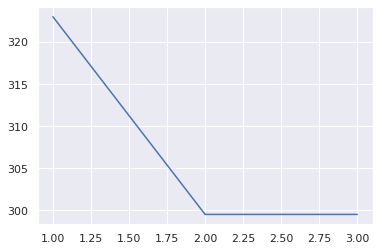

In [31]:
plt.plot([x[0] for x in training_losses], [x[1] for x in training_losses])
plt.show()

# Evaluate Model

In [23]:
preds = net(X_train.to(device)).detach().cpu().numpy()
MSE(preds, y_train.cpu(), squared=False)

299.447

In [24]:
preds = net(X_test.to(device)).detach().cpu().numpy()
MSE(preds, y_test.cpu(), squared=False)

695.9684

In [25]:
MSE(np.full(preds.shape, y_train.mean()), y_test.cpu(), squared=False)

699.8297

# Make Predictions

In [26]:
# prediction
df_te = df_te[df_te['MISSING_DATA']==False]

# drop inputs not in test set
X_out = df_te[features_to_use]
# for feat in features_to_use:
#     X_out = drop_not_in_testing(X_out, feat)
# ohe
for feat in features_to_use:
    X_out = compute_ohe(X_out, feat)
X_out = X_out.drop(columns=features_to_use)

X_out = torch.from_numpy(X_out.values).to(torch.float32)

In [27]:
preds_out = net(X_out.to(device)).detach().cpu().numpy()
df_out = pd.DataFrame(data = {'TRIP_ID': np.array(df_te['TRIP_ID']), 'TRAVEL_TIME': preds_out.flatten()})
df_out.to_csv('my_preds.csv', index=False)